## Load Modules

In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img,ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization,Conv2D,MaxPooling2D

## Tensorflow Version & GPU checking

In [2]:
tf.__version__

'2.9.0'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17959498544637964372
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1738696295
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8572484806659272358
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Load Dataset

In [4]:
Train_Dir = '../../Datasets/COVID-19/train/'
Test_Dir = '../../Datasets/COVID-19/test'

### Create Testing Directory

In [5]:
def move_imgs(imgs_list,src,dst):
    for img in imgs_list:
        shutil.move(f'{src}/{img}',f'{dst}/{img}')

In [6]:
if not os.path.exists(Test_Dir):
    os.makedirs(Test_Dir)
    for label in os.listdir(Train_Dir):
        imgs = os.listdir(Train_Dir+'/'+label)
        test_imgs = random.sample(imgs,int((len(imgs)*20)/100))
        os.makedirs(Test_Dir+'/'+label)
        move_imgs(test_imgs,f'{Train_Dir}/{label}',f'{Test_Dir}/{label}')

## Generator

In [7]:
gen = ImageDataGenerator(rescale=1./255.0)

In [8]:
Train_Data = gen.flow_from_directory(Train_Dir,target_size=(128,128),shuffle=True,batch_size=64)
Test_Data = gen.flow_from_directory(Test_Dir,target_size=(128,128),shuffle=True,batch_size=64)

Found 6444 images belonging to 2 classes.
Found 1610 images belonging to 2 classes.


In [9]:
Train_Data.class_indices

{'COVID': 0, 'Non-COVID': 1}

## Model

In [10]:
Base_Model = ResNet152V2(include_top=False,input_shape=(128,128,3))

In [11]:
Base_Model.trainable = False

In [12]:
def classification_layer():
    Classification_Layer = [
    Flatten(),
    BatchNormalization(),
    Dense(units=64,activation='tanh'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(units=32,activation='tanh'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(units=2,activation='softmax')
    ]
    return Classification_Layer

In [13]:
model = [Base_Model]
for cls_layer in classification_layer():
    model.append(cls_layer)

In [14]:
final_model = Sequential(model)

In [15]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

## Compile

In [16]:
callback = EarlyStopping(monitor='loss',patience=3)

In [17]:
checkpoint = ModelCheckpoint(filepath='../../Models/COVID/Covid.hdf5',monitor='val_loss',save_best_only=True,verbose=0,mode='auto')

In [18]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

## Training

In [19]:
history = final_model.fit(Train_Data,validation_data=Test_Data,epochs=100,callbacks=[callback,checkpoint])

Epoch 1/100
101/101 [==============================] - 51s 393ms/step - loss: 0.4168 - acc: 0.8259 - val_loss: 0.2599 - val_acc: 0.8938
Epoch 2/100
101/101 [==============================] - 43s 423ms/step - loss: 0.2145 - acc: 0.9165 - val_loss: 0.1859 - val_acc: 0.9205
Epoch 3/100
101/101 [==============================] - 43s 425ms/step - loss: 0.1508 - acc: 0.9432 - val_loss: 0.1751 - val_acc: 0.9292
Epoch 4/100
101/101 [==============================] - 42s 418ms/step - loss: 0.1209 - acc: 0.9556 - val_loss: 0.1619 - val_acc: 0.9354
Epoch 5/100
101/101 [==============================] - 40s 390ms/step - loss: 0.1008 - acc: 0.9592 - val_loss: 0.1733 - val_acc: 0.9360
Epoch 6/100
101/101 [==============================] - 50s 471ms/step - loss: 0.0848 - acc: 0.9685 - val_loss: 0.1766 - val_acc: 0.9329
Epoch 7/100
101/101 [==============================] - 52s 512ms/step - loss: 0.0843 - acc: 0.9688 - val_loss: 0.1765 - val_acc: 0.9416
Epoch 8/100
101/101 [===========================

## Save Model

In [20]:
final_model.save('../../Models/COVID/Covid.h5')

## Graph

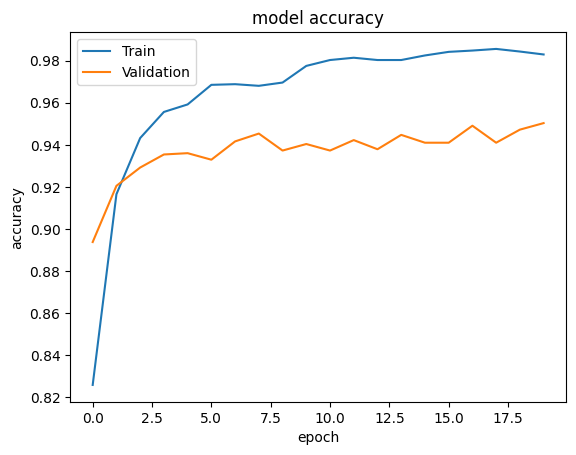

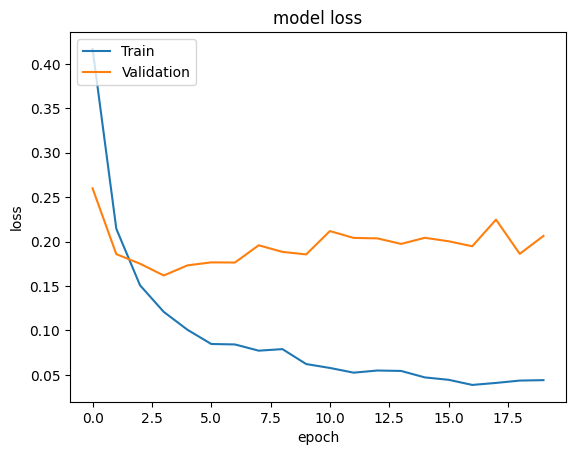

In [21]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()